## Importing All The Important Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')



## 1. Data Exploration and Visualization

In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load the dataset
data = load_breast_cancer()
X = data.data
y = data.target
feature_names = data.feature_names
target_names = data.target_names

# Create DataFrame for better visualization
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y
df['diagnosis'] = df['target'].map({0: 'Malignant', 1: 'Benign'})

print("Dataset Shape:", X.shape)
print("Target Distribution:")
print(df['diagnosis'].value_counts())
print("\nFeature Names:")
print(feature_names)

Dataset Shape: (569, 30)
Target Distribution:
diagnosis
Benign       357
Malignant    212
Name: count, dtype: int64

Feature Names:
['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


## 1.2 Correlation Between the Features

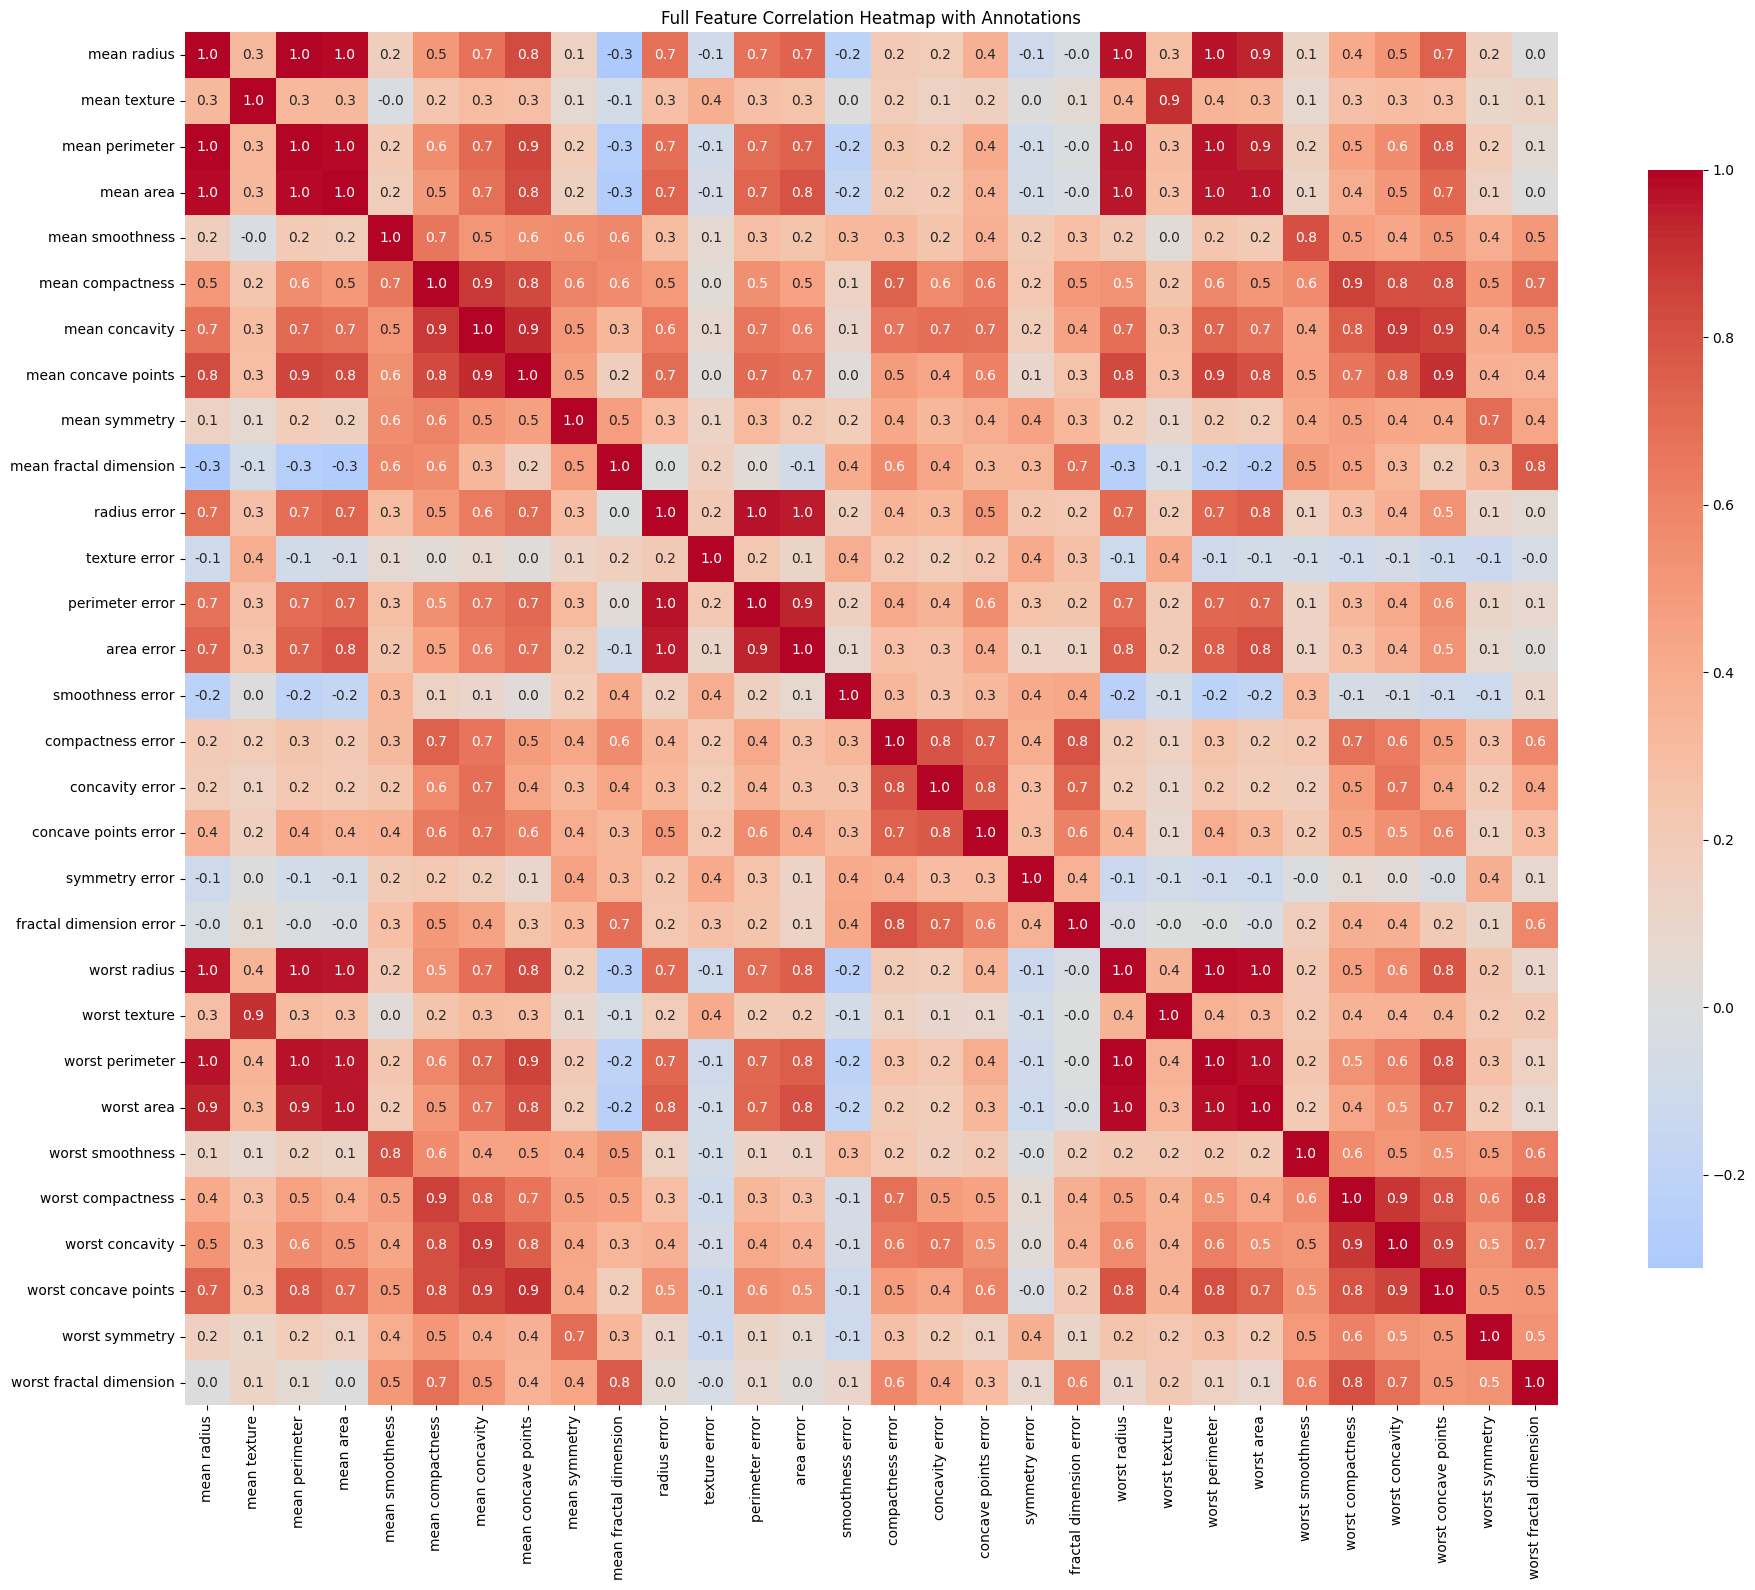

In [3]:
## 1.2 Correlation Between the Features
# Correlation Heatmap with Annotations
plt.figure(figsize=(20, 16)) # Increased figure size for better annotation visibility
correlation_matrix = df.drop(['target', 'diagnosis'], axis=1).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, cbar_kws={"shrink": .8}, fmt='.1f') # annot=True, removed mask, added fmt for annotation format
plt.title('Full Feature Correlation Heatmap with Annotations')
plt.tight_layout()
plt.show()

## 1.3 Top 5 Most Important Features

In [4]:
correlation_with_target = df.drop('diagnosis', axis=1).corr()['target'].abs().sort_values(ascending=False)
top_5_features = correlation_with_target.index[1:6]  # Exclude target itself

print("Top 5 Most Important Features:")
for i, feature in enumerate(top_5_features, 1):
    print(f"{i}. {feature}: {correlation_with_target[feature]:.4f}")

Top 5 Most Important Features:
1. worst concave points: 0.7936
2. worst perimeter: 0.7829
3. mean concave points: 0.7766
4. worst radius: 0.7765
5. mean perimeter: 0.7426


## 1.4 Pairplot of Top 5 Features

<Figure size 1500x1200 with 0 Axes>

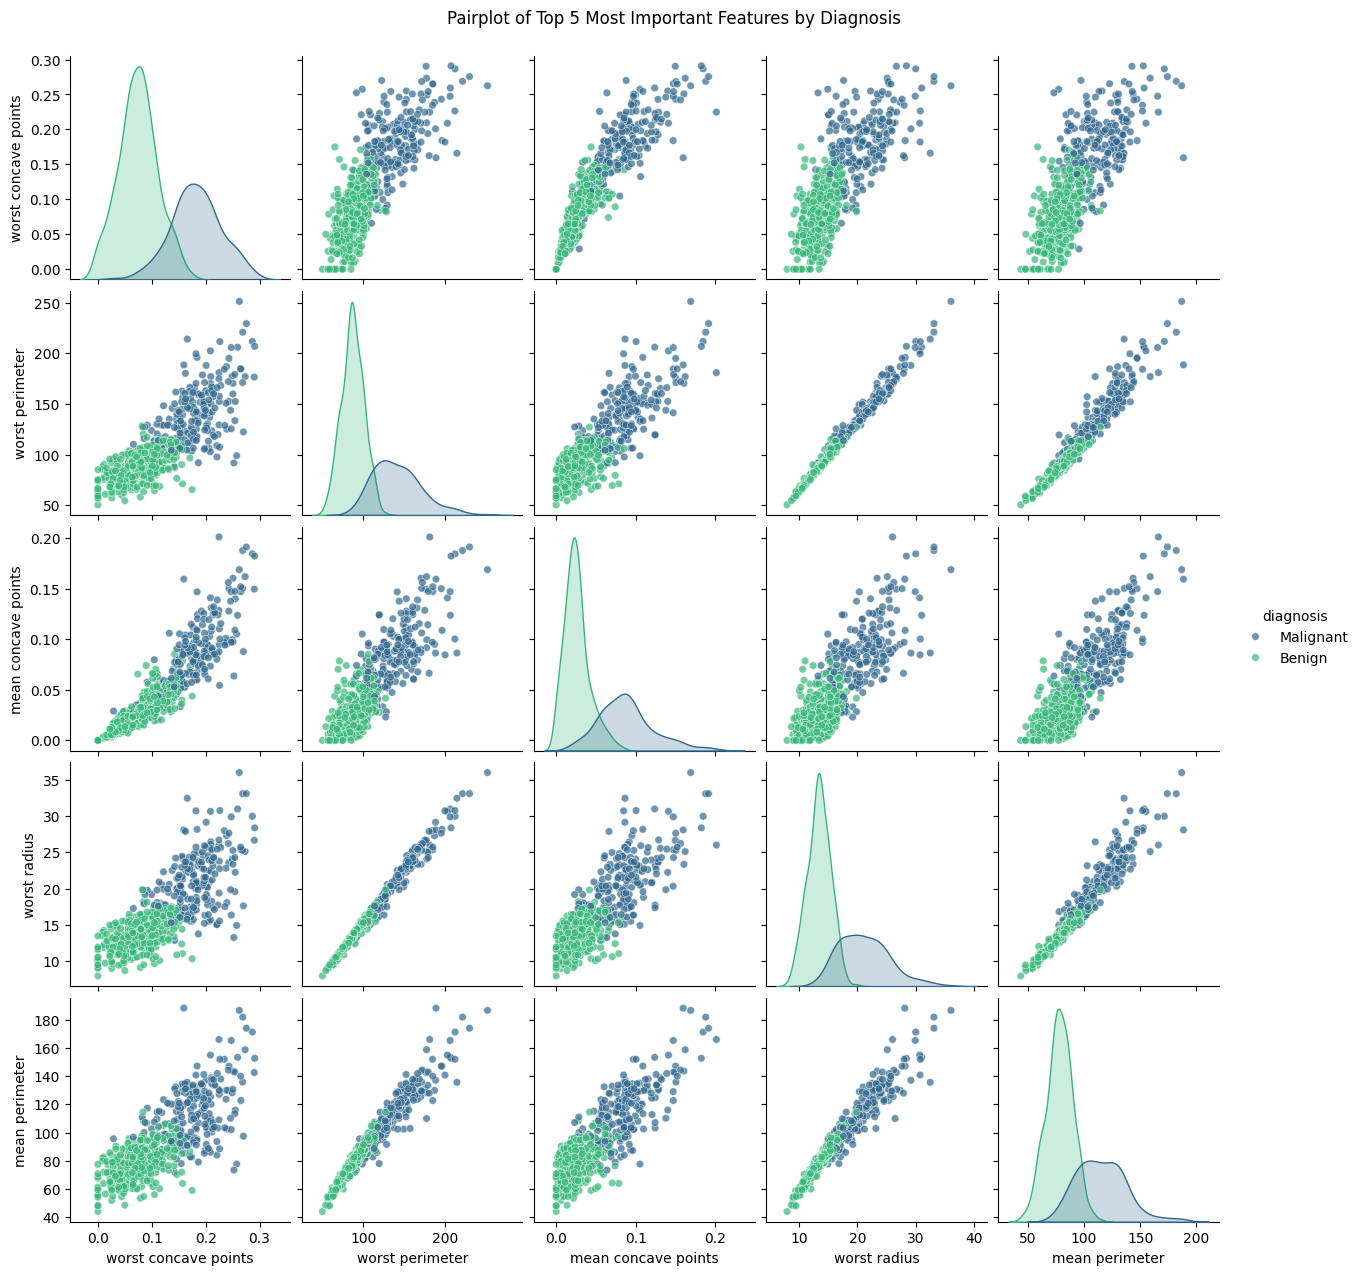

In [5]:
plt.figure(figsize=(15, 12))
pairplot_df = df[list(top_5_features) + ['diagnosis']]
sns.pairplot(pairplot_df, hue='diagnosis', palette='viridis',
             plot_kws={'alpha': 0.7, 's': 30})
plt.suptitle('Pairplot of Top 5 Most Important Features by Diagnosis', y=1.02)
plt.show()

## 1.5 Boxplots for Top 5 Features

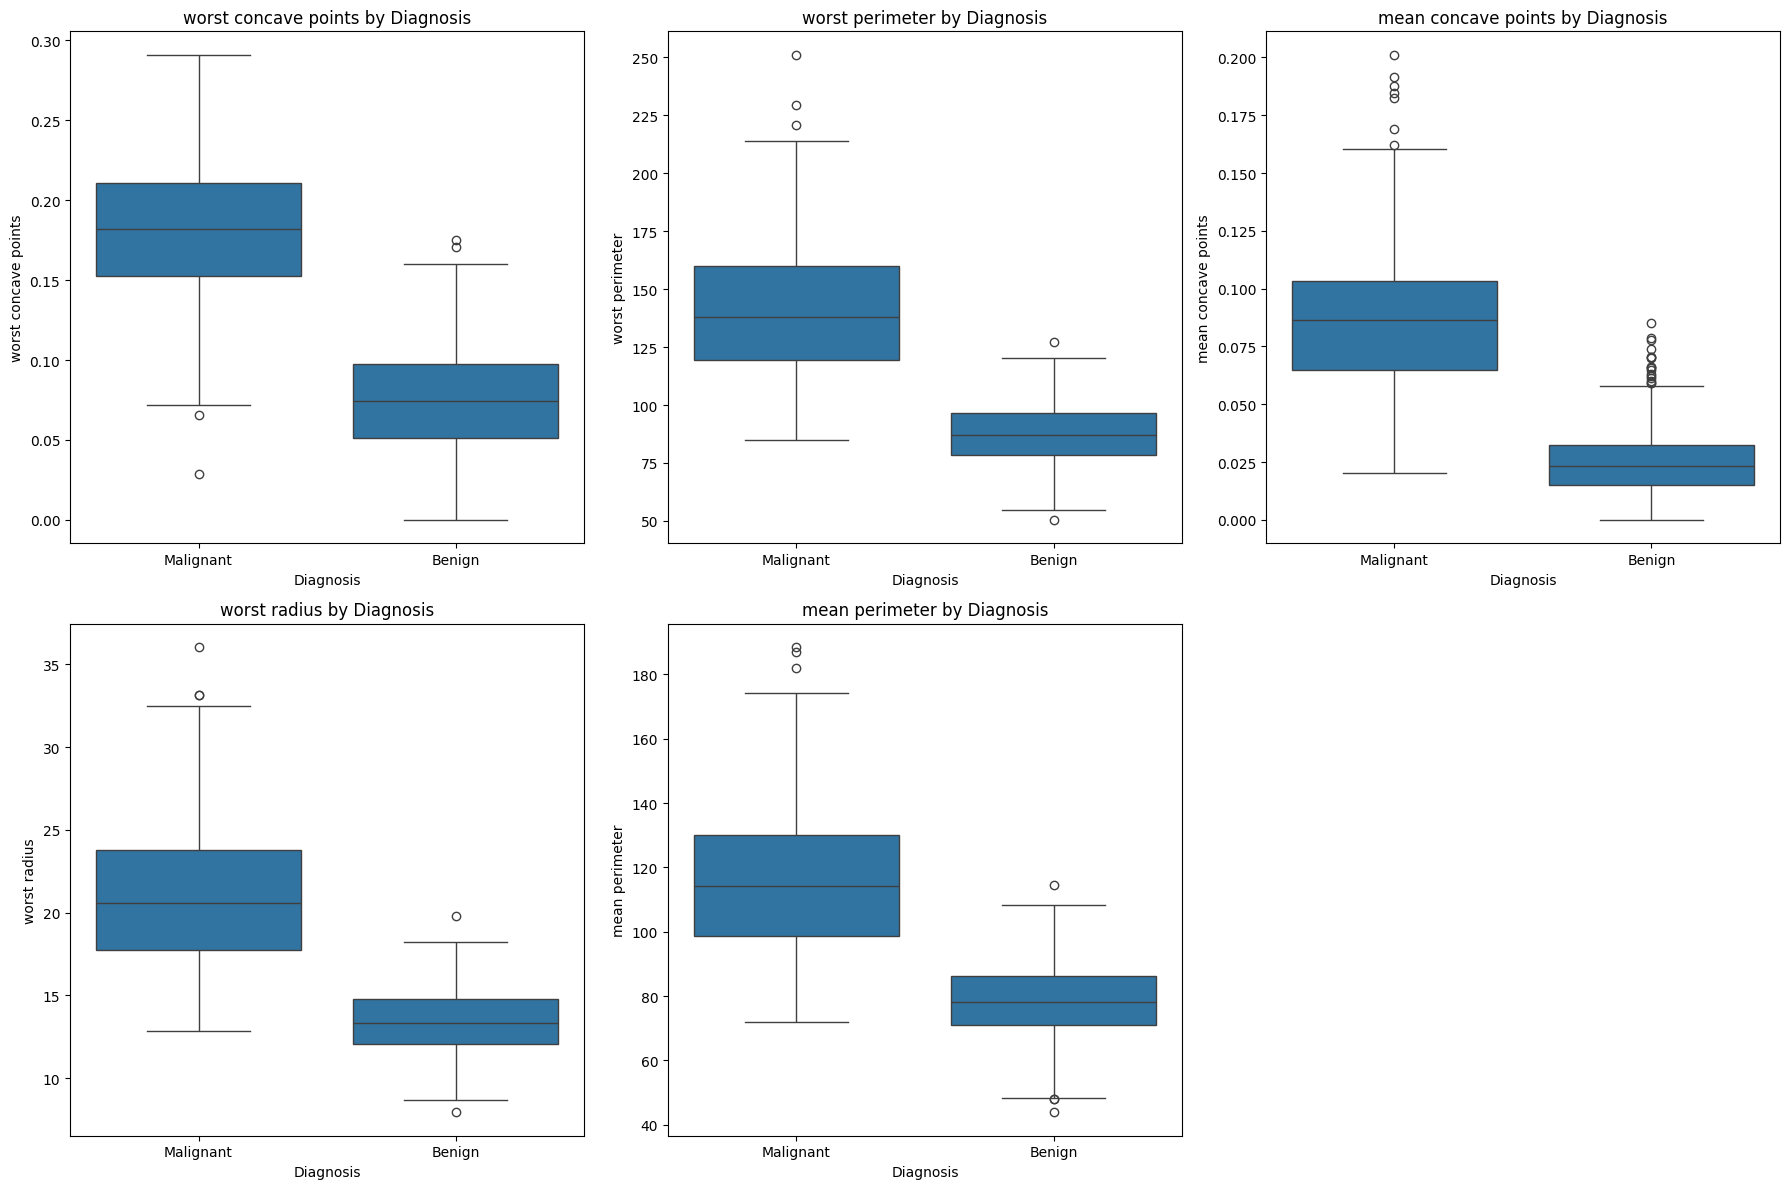

In [6]:

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, feature in enumerate(top_5_features):
    sns.boxplot(x='diagnosis', y=feature, data=df, ax=axes[i])
    axes[i].set_title(f'{feature} by Diagnosis')
    axes[i].set_xlabel('Diagnosis')
    axes[i].set_ylabel(feature)

# Remove empty subplot
fig.delaxes(axes[5])
plt.tight_layout()
plt.show()


## 1.6 Violin Plots for Top Features

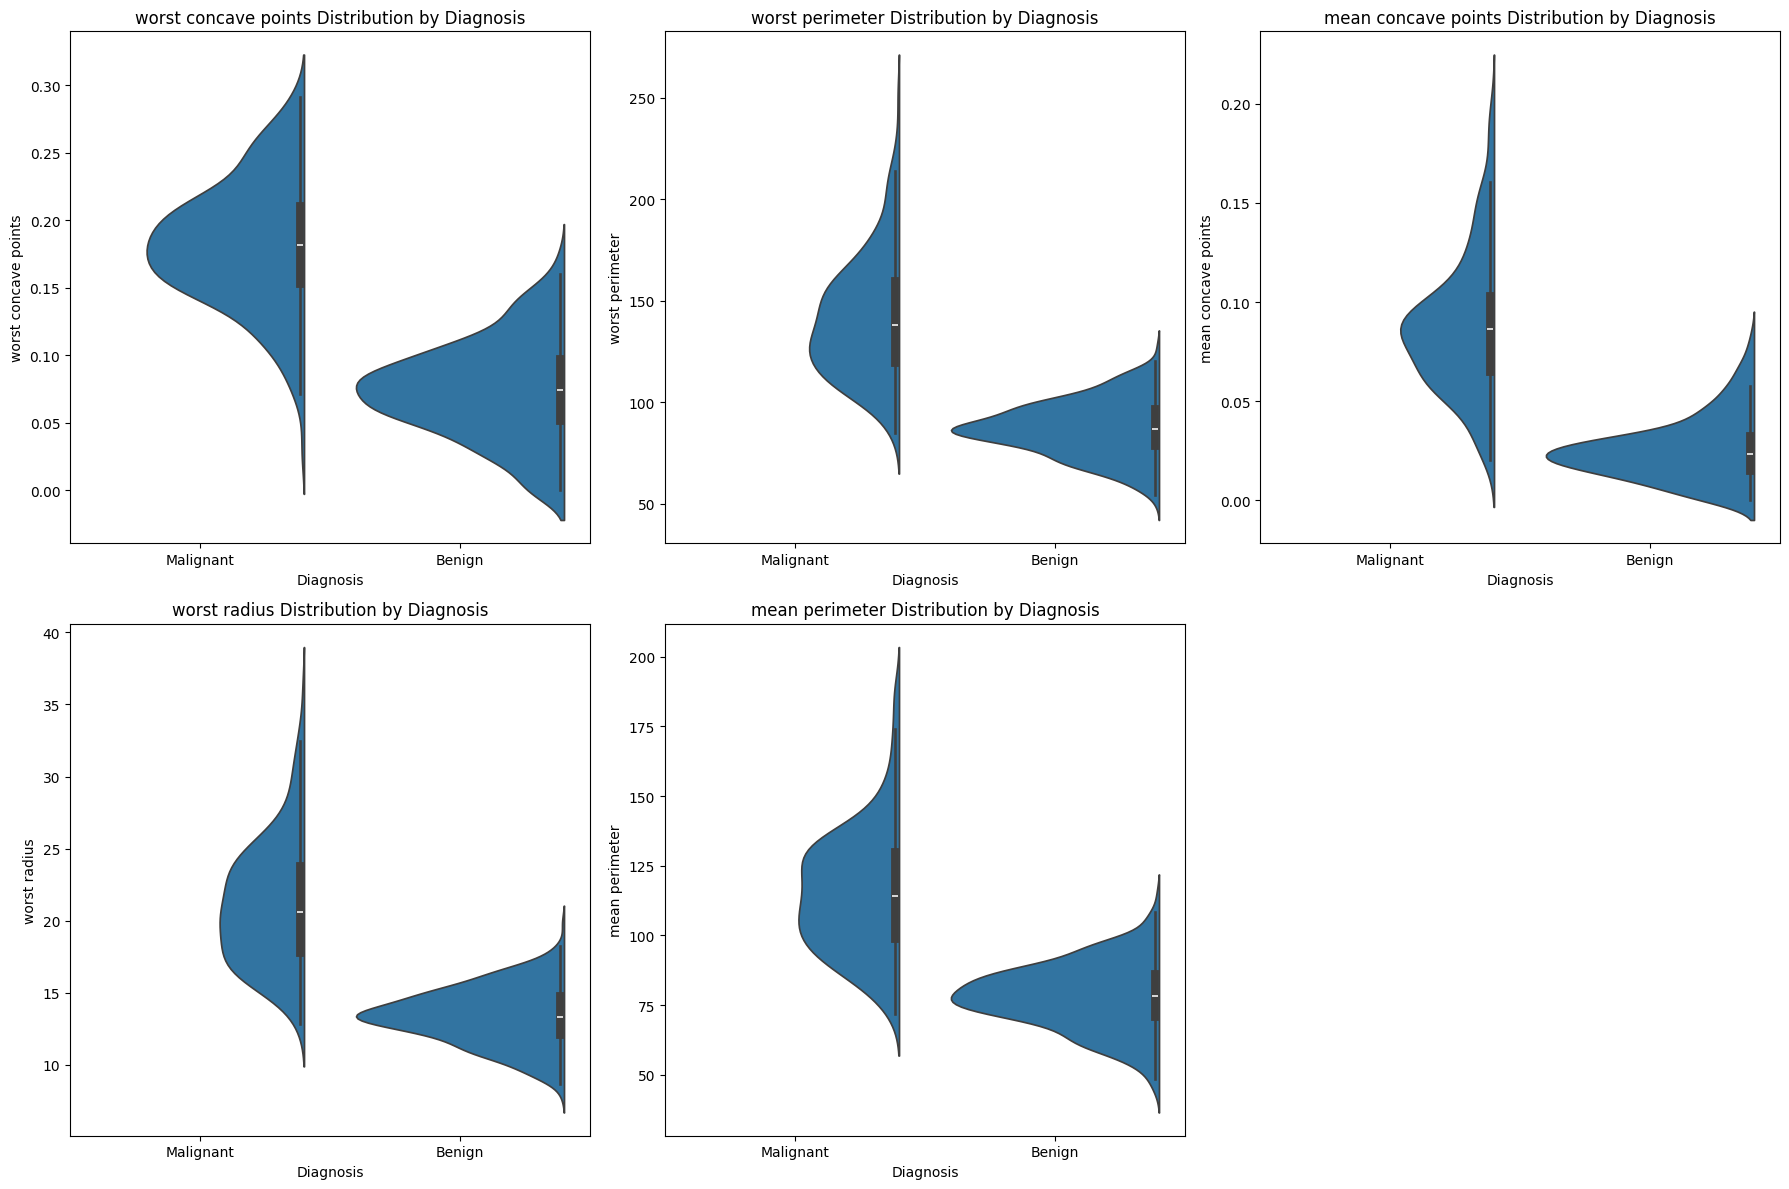

In [7]:

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, feature in enumerate(top_5_features):
    sns.violinplot(x='diagnosis', y=feature, data=df, ax=axes[i], split=True)
    axes[i].set_title(f'{feature} Distribution by Diagnosis')
    axes[i].set_xlabel('Diagnosis')
    axes[i].set_ylabel(feature)

fig.delaxes(axes[5])
plt.tight_layout()
plt.show()

## 1.7 Distribution Plots for Top Features

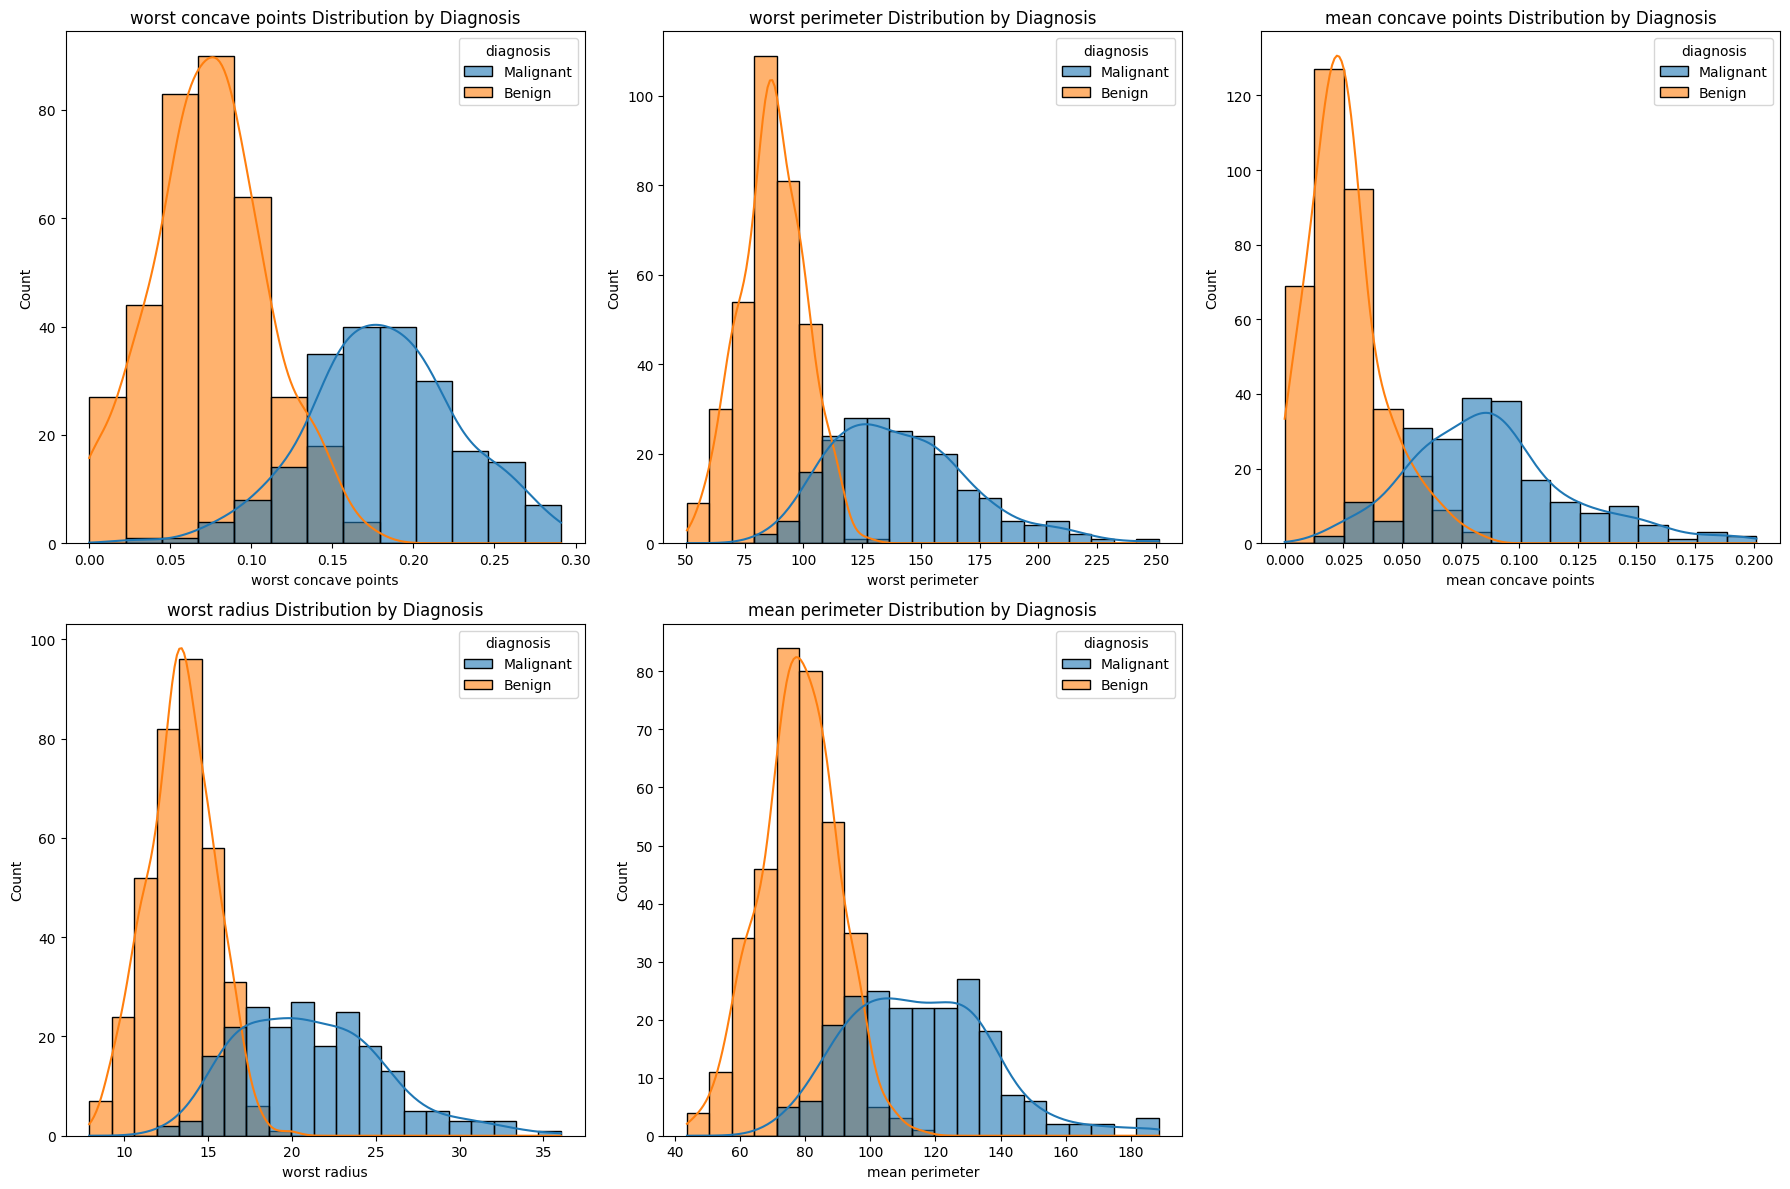

In [8]:

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, feature in enumerate(top_5_features):
    sns.histplot(data=df, x=feature, hue='diagnosis', kde=True, ax=axes[i], alpha=0.6)
    axes[i].set_title(f'{feature} Distribution by Diagnosis')
    axes[i].set_xlabel(feature)

fig.delaxes(axes[5])
plt.tight_layout()
plt.show()

# 2 Data preprocessing

In [9]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")
print(f"Training target distribution: {np.bincount(y_train)}")
print(f"Test target distribution: {np.bincount(y_test)}")

Training set shape: (455, 30)
Test set shape: (114, 30)
Training target distribution: [170 285]
Test target distribution: [42 72]


# 3. Deep Learning Model

In [10]:
# Build the model
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],), name="Input_layer"),
    BatchNormalization(),
    Dropout(0.1),
    
    Dense(128, activation='relu', name="First_hidden_layer"),
    BatchNormalization(),
    Dropout(0.2),

    Dense(64, activation='relu', name="Second_hidden_layer"),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu', name="Third_hidden_layer"),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(16, activation='relu', name="Fourth_hidden_layer"),
    BatchNormalization(),
    Dropout(0.1),
    
    Dense(1, activation='sigmoid', name="Output_layer")
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001, verbose=1)


In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_layer (Dense)             │ (None, 256)            │         7,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ First_hidden_layer (Dense)      │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Second_hidden_layer (Dense)     │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Third_hidden_layer (Dense)      │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Fourth_hidden_layer (Dense)     │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_layer (Dense)            │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,697 (209.75 KB)

 Trainable params: 52,705 (205.88 KB)

 Non-trainable params: 992 (3.88 KB)

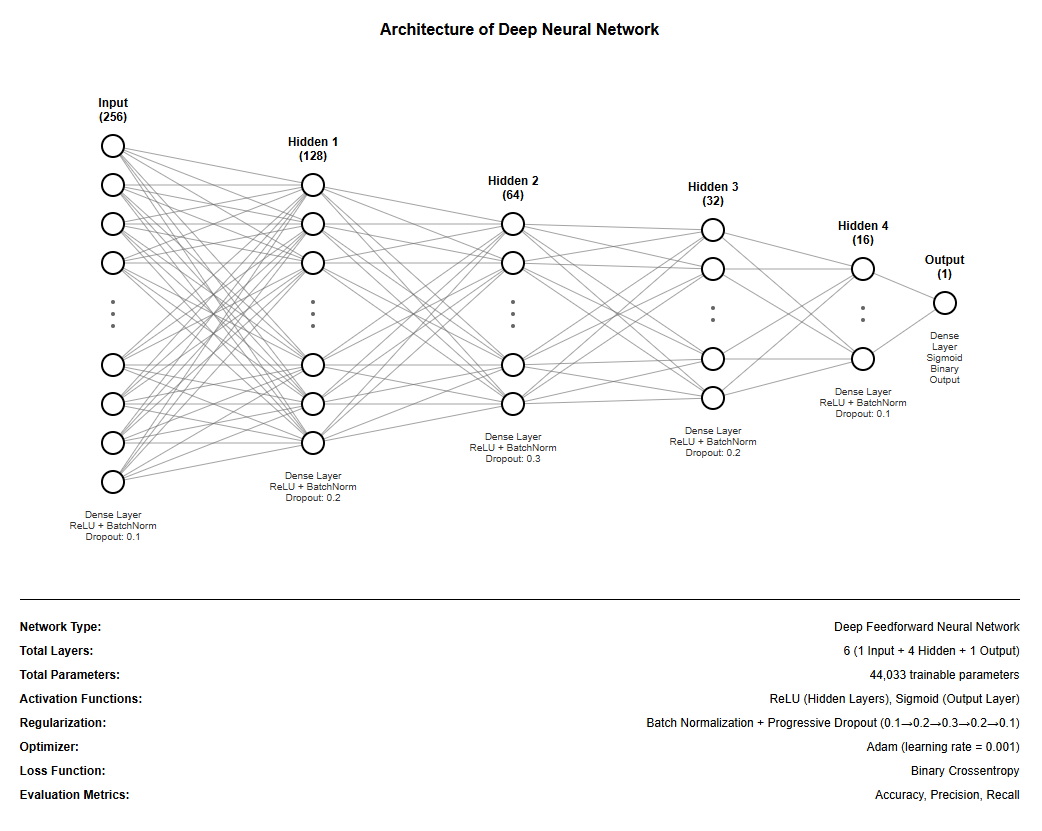

In [27]:
from IPython.display import Image, display

display(Image(filename='Model.png'))

# 4 Model Training

In [12]:
# Train the model
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100


15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - accuracy: 0.4867 - loss: 0.8246 - precision: 0.6362 - recall: 0.4410 - val_accuracy: 0.8772 - val_loss: 0.6376 - val_precision: 0.9394 - val_recall: 0.8611 - learning_rate: 0.0010
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7607 - loss: 0.4856 - precision: 0.9100 - recall: 0.6911 - val_accuracy: 0.8772 - val_loss: 0.5908 - val_precision: 0.9833 - val_recall: 0.8194 - learning_rate: 0.0010
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8051 - loss: 0.4082 - precision: 0.9282 - recall: 0.7495 - val_accuracy: 0.8772 - val_loss: 0.5505 - val_precision: 0.9833 - val_recall: 0.8194 - learning_rate: 0.0010
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8674 - loss: 0.3610 - precision: 0.9529 - recall: 0.8307 - val_accuracy: 0.9035 - val_loss: 0.5024 - val_precision: 0.9692 - val_recall: 0.8750 - learning_rate: 0.0010
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9008 - l

# 5. Model Evaluation and Advanced Plots

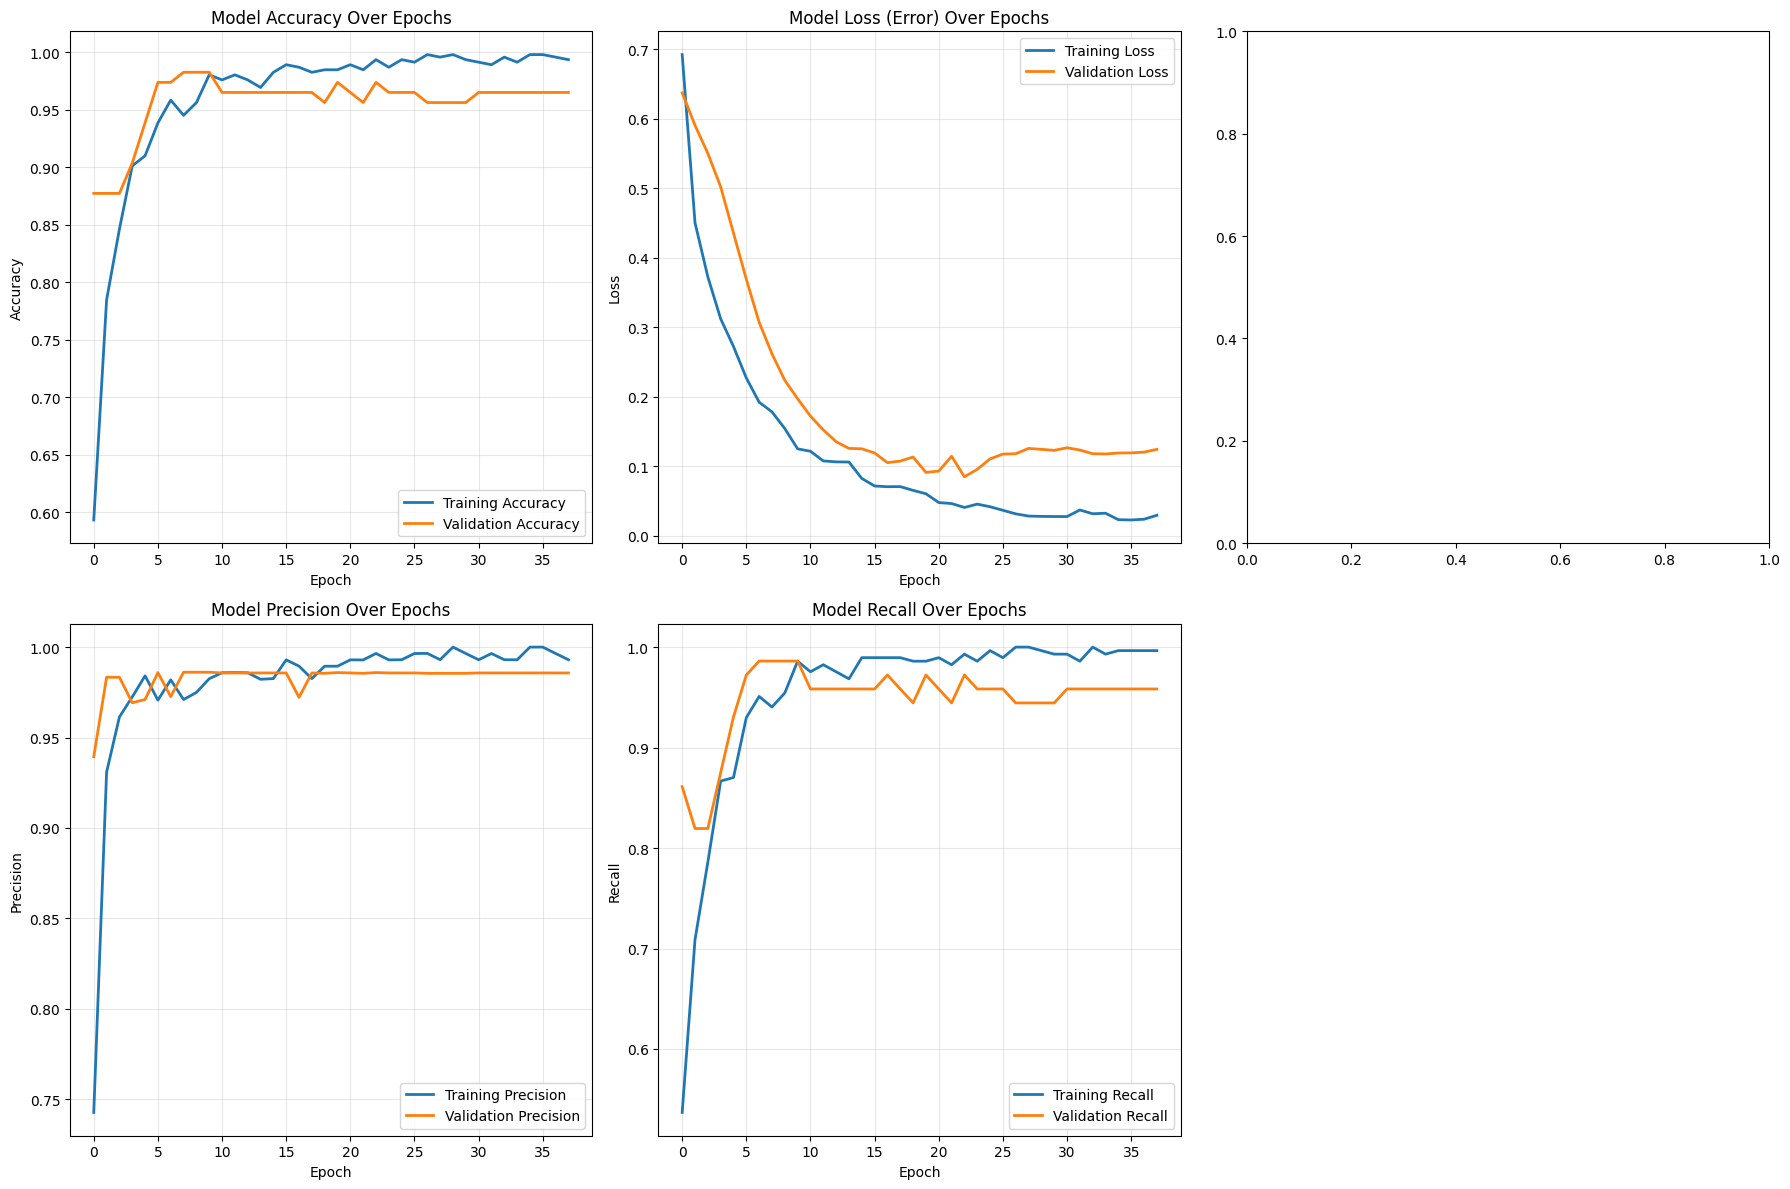

In [13]:
# 5.1 Training History Plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Accuracy plot
axes[0,0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0,0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0,0].set_title('Model Accuracy Over Epochs')
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Loss plot (Error reduction)
axes[0,1].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0,1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0,1].set_title('Model Loss (Error) Over Epochs')
axes[0,1].set_xlabel('Epoch')
axes[0,1].set_ylabel('Loss')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Learning rate decay
if 'lr' in history.history:
    axes[0,2].plot(history.history['lr'], label='Learning Rate', linewidth=2, color='purple')
    axes[0,2].set_title('Learning Rate Decay Over Epochs')
    axes[0,2].set_xlabel('Epoch')
    axes[0,2].set_ylabel('Learning Rate')
    axes[0,2].set_yscale('log')
    axes[0,2].legend()
    axes[0,2].grid(True, alpha=0.3)

# Precision
axes[1,0].plot(history.history['precision'], label='Training Precision', linewidth=2)
axes[1,0].plot(history.history['val_precision'], label='Validation Precision', linewidth=2)
axes[1,0].set_title('Model Precision Over Epochs')
axes[1,0].set_xlabel('Epoch')
axes[1,0].set_ylabel('Precision')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Recall
axes[1,1].plot(history.history['recall'], label='Training Recall', linewidth=2)
axes[1,1].plot(history.history['val_recall'], label='Validation Recall', linewidth=2)
axes[1,1].set_title('Model Recall Over Epochs')
axes[1,1].set_xlabel('Epoch')
axes[1,1].set_ylabel('Recall')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

# Remove empty subplot
fig.delaxes(axes[1,2])
plt.tight_layout()
plt.show()



4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step


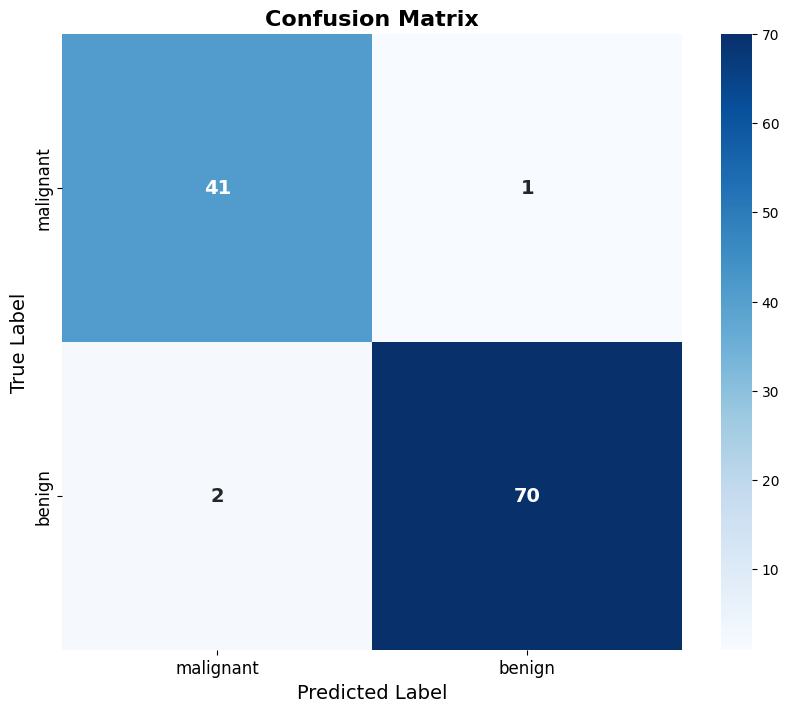

In [14]:
# 5.2 Make predictions
y_pred_proba = model.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5).astype(int)

# 5.3 Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names,
            annot_kws={'size': 14, 'weight': 'bold'})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()



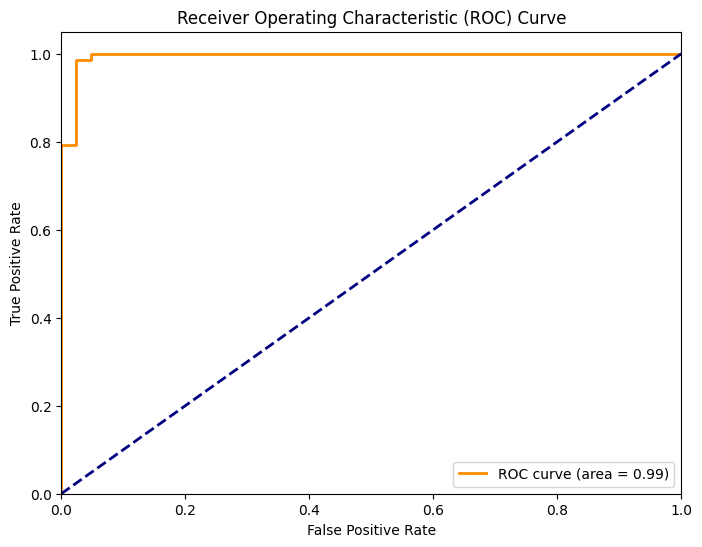

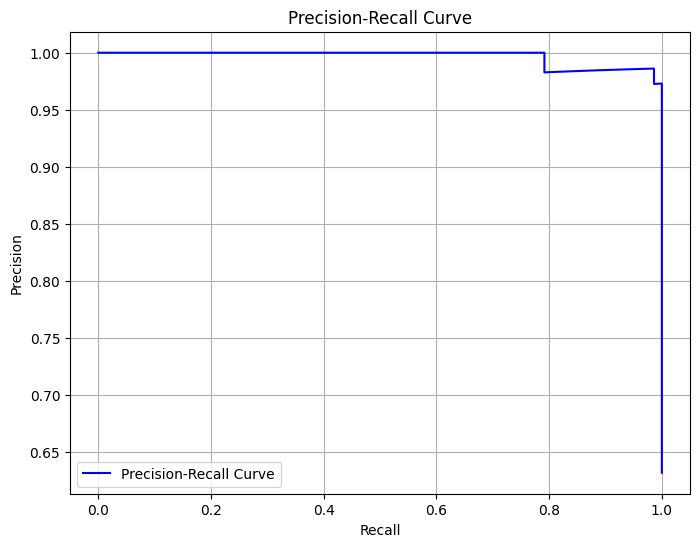

In [15]:
# ROC Curve and AUC
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

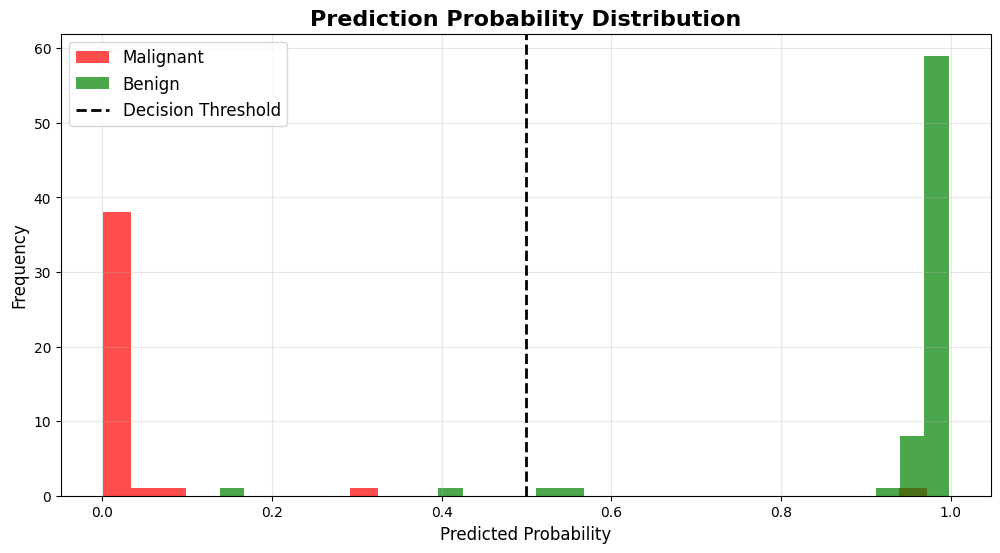

In [16]:
# 5.7 Prediction Distribution
plt.figure(figsize=(12, 6))
plt.hist(y_pred_proba[y_test == 0], alpha=0.7, label='Malignant', bins=30, color='red')
plt.hist(y_pred_proba[y_test == 1], alpha=0.7, label='Benign', bins=30, color='green')
plt.axvline(0.5, color='black', linestyle='--', linewidth=2, label='Decision Threshold')
plt.title('Prediction Probability Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Probability', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)


FINAL MODEL EVALUATION
Final Validation Accuracy: 0.9649
Final Validation Loss: 0.1246
ROC AUC Score: 0.9947

Classification Report:
              precision    recall  f1-score   support

   malignant       0.95      0.98      0.96        42
      benign       0.99      0.97      0.98        72

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



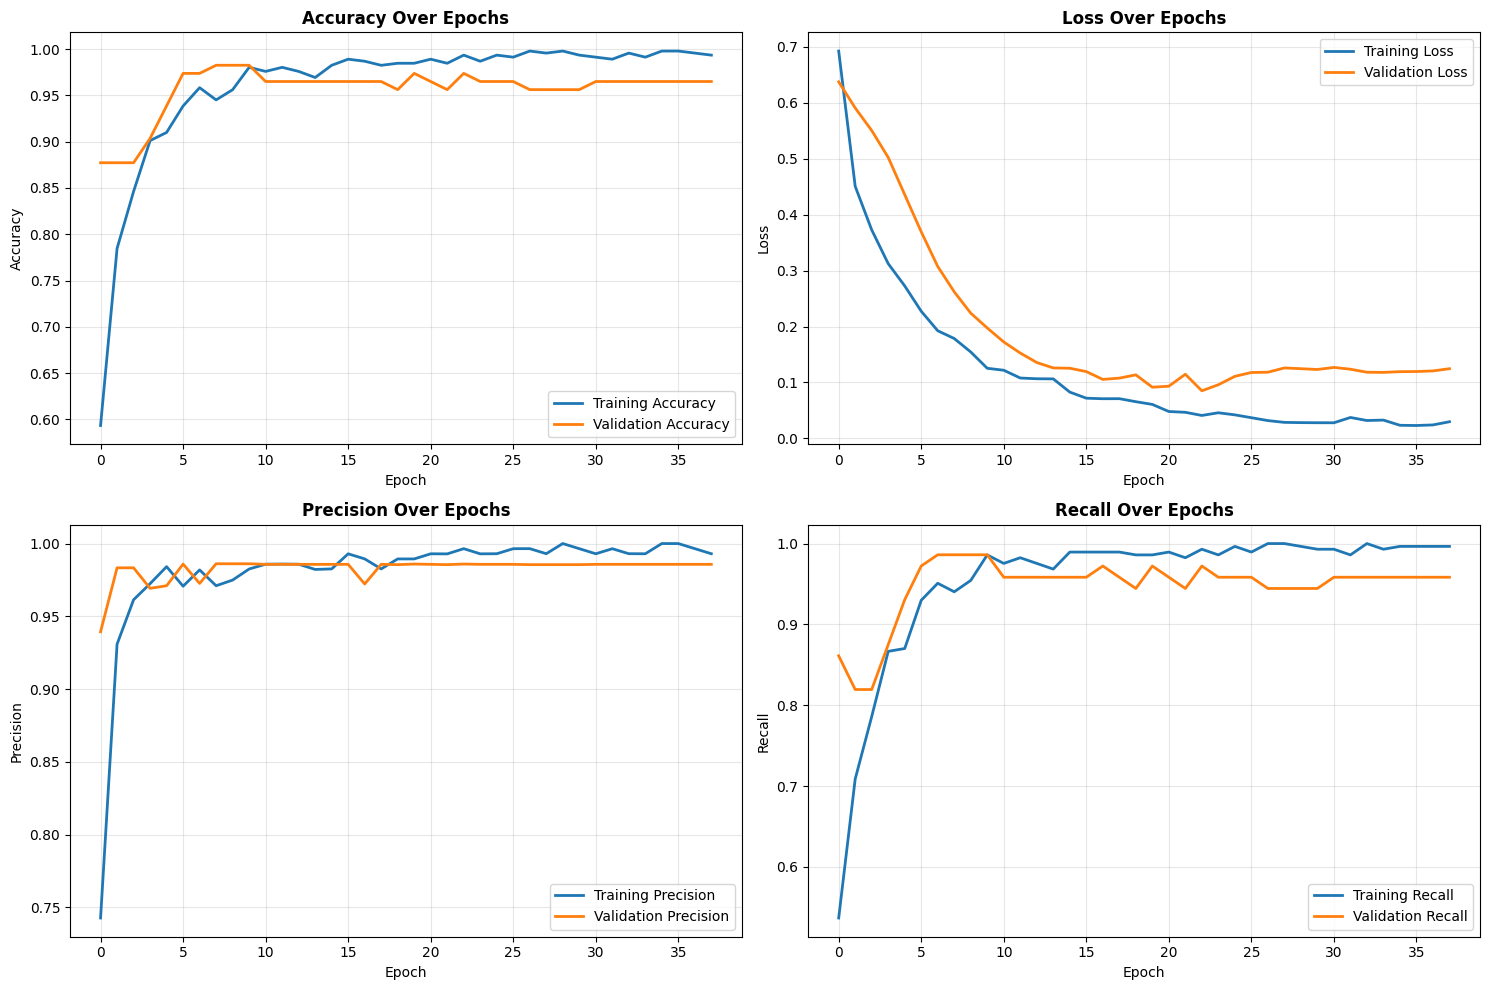


TRAINING SUMMARY
Total Epochs Trained: 38
Best Validation Accuracy: 0.9825
Best Validation Loss: 0.0851
Final Learning Rate: 0.001000


In [17]:
#  Final Evaluation
print("\n" + "="*60)
print("FINAL MODEL EVALUATION")
print("="*60)

# Calculate final metrics
final_accuracy = history.history['val_accuracy'][-1]
final_loss = history.history['val_loss'][-1]

print(f"Final Validation Accuracy: {final_accuracy:.4f}")
print(f"Final Validation Loss: {final_loss:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))


# Training vs Validation Metrics Comparison
metrics = ['accuracy', 'loss', 'precision', 'recall']
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, metric in enumerate(metrics):
    if metric in history.history:
        axes[i].plot(history.history[metric], label=f'Training {metric.title()}', linewidth=2)
        axes[i].plot(history.history[f'val_{metric}'], label=f'Validation {metric.title()}', linewidth=2)
        axes[i].set_title(f'{metric.title()} Over Epochs', fontsize=12, fontweight='bold')
        axes[i].set_xlabel('Epoch')
        axes[i].set_ylabel(metric.title())
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)
print(f"Total Epochs Trained: {len(history.history['loss'])}")
print(f"Best Validation Accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"Best Validation Loss: {min(history.history['val_loss']):.4f}")
print(f"Final Learning Rate: {history.history.get('lr', [0.001])[-1]:.6f}")

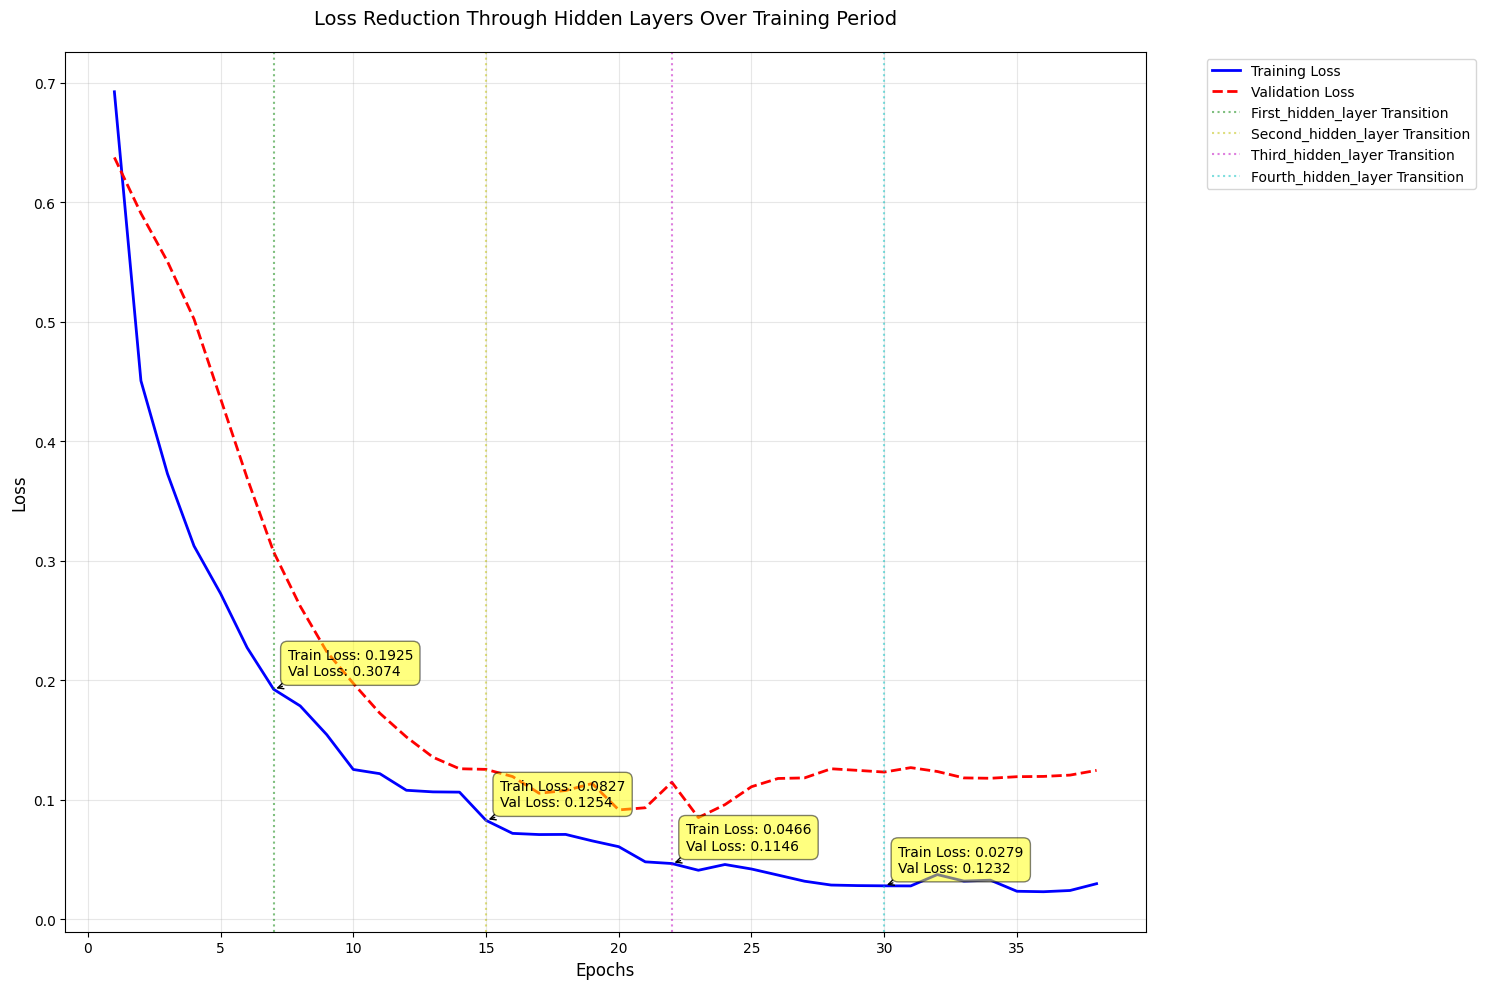

In [18]:
# Create a figure with a larger size
plt.figure(figsize=(15, 10))

# Get the layer names and their weights before and after training
layer_names = [layer.name for layer in model.layers if 'hidden' in layer.name.lower()]

# Plot training loss
epochs = range(1, len(history.history['loss']) + 1)
plt.plot(epochs, history.history['loss'], 'b-', label='Training Loss', linewidth=2)
plt.plot(epochs, history.history['val_loss'], 'r--', label='Validation Loss', linewidth=2)

# Add vertical lines to indicate layer transitions
colors = ['g', 'y', 'm', 'c']
for i, layer_name in enumerate(layer_names):
        transition_point = (i + 1) * len(epochs) // (len(layer_names) + 1)
        plt.axvline(x=transition_point, color=colors[i], linestyle=':', label=f'{layer_name} Transition', alpha=0.5)

plt.title('Loss Reduction Through Hidden Layers Over Training Period', fontsize=14, pad=20)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add annotations for loss values at layer transitions
for i, layer_name in enumerate(layer_names):
        transition_point = (i + 1) * len(epochs) // (len(layer_names) + 1)
        train_loss = history.history['loss'][transition_point-1]
        val_loss = history.history['val_loss'][transition_point-1]
        plt.annotate(f'Train Loss: {train_loss:.4f}\nVal Loss: {val_loss:.4f}', 
                                xy=(transition_point, train_loss),
                                xytext=(10, 10),
                                textcoords='offset points',
                                bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                                arrowprops=dict(arrowstyle='->'))

plt.tight_layout()
plt.show()